In [1]:
import os
import sys
# Load the local code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.read_parallel import read_parallel_local
import pandas as pd

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
REDUCE_BY_FACTOR = 20.0 # Make the dataset smaller for development purposes
train_test_ratio = 0.10
train_valid_ratio = 0.80
first_n_words = 512
destination_folder = 'bert_classification'

if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/home/luke/tmp_vol'
else:
    DATA_VOL = os.environ['DATA_VOL']
    
# Pre-wrangled metadata
df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.id = df.id.astype(int)    
print(f"Original number of examples: {len(df)}")
df = df.sample(n=int(len(df)/REDUCE_BY_FACTOR)) #
print(f"Reduced number of examples:  {len(df)}")

df['text'] = read_parallel_local(df['id'], DATA_VOL + "/clean/")
df = df.reset_index(drop=True)

Original number of examples: 199451
Reduced number of examples:  9972
Took 0.5942928314208984 min to open 9972 files with 20 processes.


In [4]:
df.head()

,bill_id,version_number,id,partisan_lean,sc_id,signed,text
0,1138388,1,2179550,0.738123,592-1,0,new york state assembly speaker carl e. heast...
1,1298109,1,2534396,0.243779,562-2,0,<billno> <sponsor> house bill by miller an ac...
2,1224465,2,2366356,0.230769,567-2,0,1 house of representatives floor version state...
3,1289545,1,2521382,0.579069,636-1,0,second regular session seventy-second general...
4,1285537,1,2516924,0.294479,627-1,0,second regular session senate bill no. 100th ...


In [5]:
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x
    
for i in range(len(df)):
    df.at[i, 'text'] = trim_string(df.at[i, 'text'])

In [6]:
# Train-test split
df_train_full, df_test = train_test_split(df, train_size = train_test_ratio, random_state = 1, stratify = df.signed.values)
# Train-valid split
df_train, df_valid = train_test_split(df_train_full, train_size = train_valid_ratio, random_state = 1, stratify = df_train_full.signed.values)

In [62]:
print(f"Training size: {df_train.shape}")
print(f"Validation size: {df_valid.shape}")
print(f"Test size: {df_test.shape}")

Training size: (797, 7)
Validation size: (200, 7)
Test size: (8975, 7)


In [7]:
!nvidia-smi

Fri Feb 26 15:51:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    On   | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P0    29W / 185W |    639MiB /  8111MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [9]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [11]:
#!pip install -Uqr models/official/requirements.txt
#f.device()

In [22]:
train_data1 = tf.data.Dataset.from_tensor_slices((df_train['text'].values, df_train['signed'].values))
val_data1 = tf.data.Dataset.from_tensor_slices((df_valid['text'].values, df_valid['signed'].values))
test_data1 = tf.data.Dataset.from_tensor_slices((df_test['text'].values, df_test['signed'].values))

In [13]:
for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b"legislature of the state of idaho sixty-fifth legislature second regular session in the house of representatives house bill no. by education committee an act relating to education; amending chapter title idaho code, by the addition of a new section idaho code, to provide for a statewide online student literacy and academic text support system. be it enacted by the legislature of the state of idaho: section that chapter title idaho code, be, and the same is hereby amended by the addition thereto of a new section, to be known and designated as idaho code, and to read as follows: reading resources legislative findings. the legislature finds that reading skills are paramount to students' academic and career success. the legislature further finds that not all schools are able to provide adequate access to academic texts to support student learning. to ensure that districts and schools have adequate resources, the state department of education shall make available a statewide onl

In [14]:
train_batch_size = 32

In [15]:
max_seq_length = 128  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])



In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
label_list = [0,1]

In [17]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  
    example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
    
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)



In [49]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, [text, label],
                                                                   Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])
    
    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    
    return (x, label_id)
    
    

In [50]:
with tf.device('/cpu:0'):
    train_data = (train_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             
             .shuffle(1000)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
             )

    val_data = (val_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
            )

In [51]:
val_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [52]:
def create_model():
        input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
        input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")
        pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
        drop = tf.keras.layers.Dropout(0.4)(pooled_output)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(drop)
        
        model = tf.keras.Model(
          inputs={
              'input_word_ids': input_word_ids,
              'input_mask': input_mask,
              'input_type_ids': input_type_ids
          },
          outputs=output
        )
        return model

In [53]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [54]:
#import pydot
#tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [55]:
epochs = 4
history = model.fit(train_data,
                   validation_data=val_data,
                   epochs=epochs,
                   verbose=1)

Epoch 1/4
24/24 [==============================] - 226s 9s/step - loss: 0.6037 - binary_accuracy: 0.7048 - val_loss: 0.4185 - val_binary_accuracy: 0.8594
Epoch 2/4
24/24 [==============================] - 216s 9s/step - loss: 0.4912 - binary_accuracy: 0.8405 - val_loss: 0.4083 - val_binary_accuracy: 0.8594
Epoch 3/4
24/24 [==============================] - 217s 9s/step - loss: 0.4246 - binary_accuracy: 0.8569 - val_loss: 0.3886 - val_binary_accuracy: 0.8594
Epoch 4/4
24/24 [==============================] - 219s 9s/step - loss: 0.3819 - binary_accuracy: 0.8591 - val_loss: 0.3576 - val_binary_accuracy: 0.8594


In [58]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

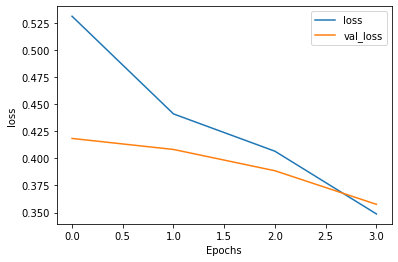

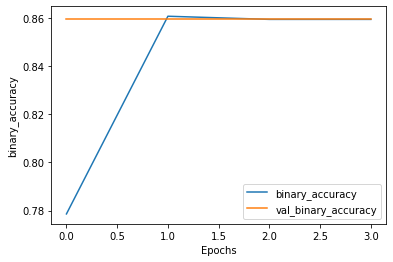

In [61]:
plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

AttributeError: module 'tensorflow' has no attribute 'Session'

In [64]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [65]:
tf.config.list_physical_devices('GPU')

[]